In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"C:\Users\navya\Downloads\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
print("[INFO] loading images...")

[INFO] loading images...


In [5]:
data = []
labels = []


In [8]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)


In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [11]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")


In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 3s 0us/step


In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
for layer in baseModel.layers:
    layer.trainable = False


In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...


C:\Users\navya\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
287/287 [==============================] - 351s 1s/step - loss: 0.2151 - accuracy: 0.9329 - val_loss: 0.0651 - val_accuracy: 0.9852
Epoch 2/20
287/287 [==============================] - 222s 775ms/step - loss: 0.0692 - accuracy: 0.9798
Epoch 3/20
287/287 [==============================] - 206s 716ms/step - loss: 0.0491 - accuracy: 0.9846
Epoch 4/20
287/287 [==============================] - 255s 887ms/step - loss: 0.0388 - accuracy: 0.9904
Epoch 5/20
287/287 [==============================] - 243s 845ms/step - loss: 0.0353 - accuracy: 0.9890
Epoch 6/20
287/287 [==============================] - 235s 817ms/step - loss: 0.0307 - accuracy: 0.9914
Epoch 7/20
287/287 [==============================] - 274s 957ms/step - loss: 0.0308 - accuracy: 0.9903
Epoch 8/20
287/287 [==============================] - 207s 720ms/step - loss: 0.0251 - accuracy: 0.9921
Epoch 9/20
287/287 [==============================] - 236s 821ms/step - loss: 0.0243 - accuracy: 0.9930
E

[INFO] evaluating network...
72/72 [==============================] - 50s 692ms/step
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00      1149
without_mask       1.00      0.99      1.00      1151

    accuracy                           1.00      2300
   macro avg       1.00      1.00      1.00      2300
weighted avg       1.00      1.00      1.00      2300

[INFO] saving mask detector model...


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

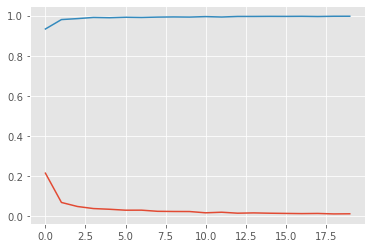

In [19]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")

plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")